In [1]:
# importing packages

import numpy as np
import scipy.stats as stats
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Simulate Data
HERITABILITY = 0.85
p = 0.05
INDIVIDUALS = 300
MARKERS = 1000

# x in {0,1,2}
X = np.random.randint(0,3, size=(INDIVIDUALS,MARKERS))

# each marker has a p chance of have a normally distributed effect
# with variance 1
effect = np.random.normal(0, 1, size=(MARKERS))
for i in range(len(effect)):
    if np.random.random() > p:
        effect[i] = 0
noise = np.random.normal(0, 1 - HERITABILITY, size=(INDIVIDUALS))

# generate phenotypes
y = (X).dot(effect) + noise


df = {'y' : y}
df.update({f'x{i}': X.T[i] for i in range(MARKERS)})
df = pd.DataFrame(df)
df.to_csv('GWAS_data.csv')

In [3]:
def compute_beta_value(X_i, y):
    # solves linear regression 
    return 1/(np.dot(X_i, X_i)) * np.dot(X_i, y-np.mean(y))

# solve linear equation for each beta
betas = np.array([compute_beta_value(x_i, y) for x_i in X.T])

Text(0, 0.5, 'beta')

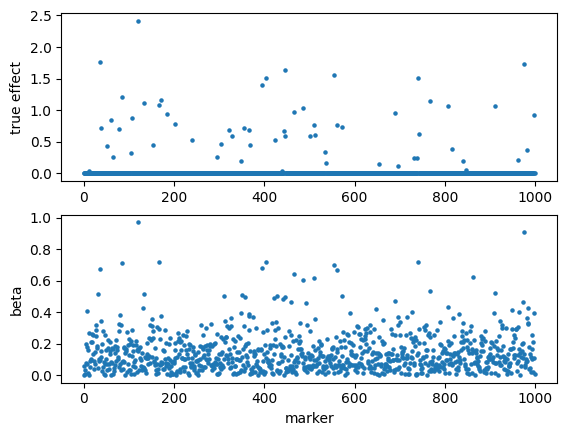

In [4]:
# Figure of betas and true phenotypes

fig, axs = plt.subplots(2,1)

axs[0].scatter(np.arange(MARKERS), np.abs(effect), s=5)
axs[1].scatter(np.arange(MARKERS), np.abs(betas), s=5)

axs[1].set_xlabel("marker")
axs[0].set_ylabel("true effect")
axs[1].set_ylabel("beta")

In [5]:
# now find p values 
critical = 0.95
p_wald = critical/MARKERS

beta_mean = sum(betas)/len(betas)
beta_variance = sum([(betas[i] - beta_mean)**2 for i in range(MARKERS)])/len(betas)

betas_normalised = (np.array([(betas[i]-beta_mean)/beta_variance for i in range(MARKERS)]))

p_values = -np.log(np.array([stats.norm.pdf(beta) for beta in betas_normalised]))


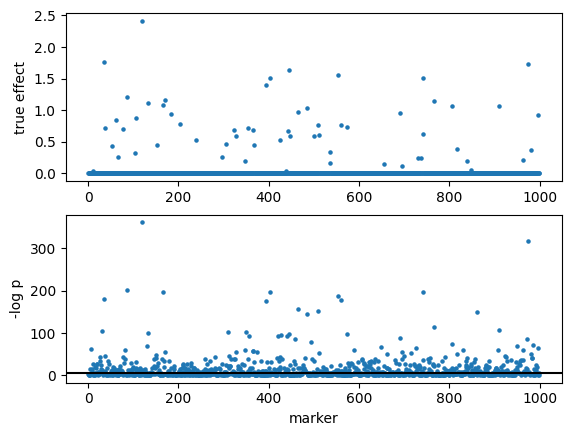

In [6]:
fig, axs = plt.subplots(2,1)

axs[0].scatter(np.arange(MARKERS), np.abs(effect), s=5)
axs[1].scatter(np.arange(MARKERS), np.abs(p_values), s=5)

axs[1].set_xlabel("marker")
axs[0].set_ylabel("true effect")
axs[1].set_ylabel("-log p")

axs[1].axhline(y=-np.log(p_wald), color='black', linestyle='-')


In [7]:
%env R_HOME = /Library/Frameworks/R.framework/Resources
%env R_LIBS_USER = /Users/paddygibbs/Library/R/arm64/4.2/library                      
%load_ext rpy2.ipython


env: R_HOME=/Library/Frameworks/R.framework/Resources
env: R_LIBS_USER=/Users/paddygibbs/Library/R/arm64/4.2/library


In addition: Warning messages:
1: In model.matrix.default(mt, mf, contrasts) :
  the response appeared on the right-hand side and was dropped
2: In model.matrix.default(mt, mf, contrasts) :
  problem with term 1 in model.matrix: no columns are assigned


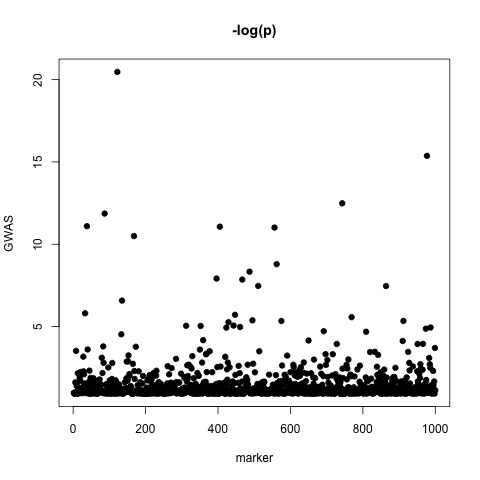

In [18]:
%%R

# Initialize a list to store model summaries
p_values <- list()

# Loop through each predictor in columns 2 to 1002
for (i in 2:1001) {
    # Extract the predictor name e.g. x1, or x2
    predictor_name <- names(df)[i]
    formula <- as.formula(paste("y ~", predictor_name))
    model <- lm(formula, data=df)

    # store p value from t statistic 
    p_values[[predictor_name]] <- dnorm(summary(model)$coefficients[, "t value"][predictor_name],
}

# log transform p values
log_p_values <- sapply(p_values, function(p) -log(p))

x <- 1:1000

# Creating the scatter plot
plot(x, log_p_values, pch = 19, main = "-log(p)", xlab = "marker", ylab = "GWAS")


In [11]:
%%R -i df

df <- read.csv('GWAS_data.csv')

# y, x1, x2, x2, ... xn

y <- df['y']  # Accessing column 'y' from the data frame

# Initialize a list to store model summaries
model_summaries <- list()

# Loop through each predictor in columns 2 to 1002 i.e. x1 ... xn
for (i in 2:ncol(df)+1) {
    # Extract the predictor name for labeling purposes
    predictor_name <- names(df)[i]

    # Fit a linear model for 'y' regressed on the current predictor
    model <- lm(y ~ df[, i], data=df)

    # Store the summary of each model in the list with the predictor name as the key
    model_summaries[[predictor_name]] <- summary(model)
}

# To display the summaries, you might print them or handle them differently based on your needs
model_summaries

Error in `[.data.frame`(df, , i) : undefined columns selected


RInterpreterError: Failed to parse and evaluate line "\ndf <- read.csv('GWAS_data.csv')\n\n# y, x1, x2, x2, ... xn\n\ny <- df['y']  # Accessing column 'y' from the data frame\n\n# Initialize a list to store model summaries\nmodel_summaries <- list()\n\n# Loop through each predictor in columns 2 to 1002 i.e. x1 ... xn\nfor (i in 2:ncol(df)+1) {\n    # Extract the predictor name for labeling purposes\n    predictor_name <- names(df)[i]\n\n    # Fit a linear model for 'y' regressed on the current predictor\n    model <- lm(y ~ df[, i], data=df)\n\n    # Store the summary of each model in the list with the predictor name as the key\n    model_summaries[[predictor_name]] <- summary(model)\n}\n\n# To display the summaries, you might print them or handle them differently based on your needs\nmodel_summaries\n".
R error message: 'Error in `[.data.frame`(df, , i) : undefined columns selected'